In [164]:
'''
Author: Onur Sevket Aslan
Start Date: 2020/08/01
Revision Date: 2020/08/15
Revision: 3

Title: Sales increase analysis for Nuveen 
'''

'\nAuthor: Onur Sevket Aslan\nStart Date: 2020/08/01\nRevision Date: 2020/08/15\nRevision: 3\n\nTitle: Sales increase analysis for Nuveen \n'

<h1>Libraries</h1>

In [165]:
#%%Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',50)
pd.set_option('display.width',200)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import linear_model
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import scikitplot as skplt

<h1>Data Ingestion</h1>

In [166]:
#%%Data ingestion
filename_x='../../Transaction Data.xlsx'
filename_firm='../../Firm Information.xlsx'
data_x=pd.read_excel(filename_x, sheet_name='Transactions18') #reading X's
data_y=pd.read_excel(filename_x, sheet_name='Transactions19') #reading Y's
firmName=pd.read_excel(filename_firm, sheet_name='Rep summary')

<h2>Join Tables</h2>

In [167]:
#Filling 0 in empty 'new_Fund_12M' where 'sales_12M' is not null
indexToFill=data_y[(data_y['sales_12M'].notnull()) & (data_y['new_Fund_added_12M'].isnull())].index
data_y.loc[indexToFill,'new_Fund_added_12M']=0

In [168]:
#%%Join tables
data_x.fillna(value=0,inplace=True) #filling NA with 0 before merging. it was difficult after merging.
data=pd.merge(data_x,data_y,how='outer',left_on='CONTACT_ID',right_on='CONTACT_ID')
# print(data.columns.values)
data=data=pd.merge(data,firmName,how='outer',left_on='CONTACT_ID',right_on='Contact ID')
data.drop(columns=['Contact ID', 'CustomerID', 'Firm ID', 'Office ID', 'Channel', 'Sub channel'], axis=1, inplace=True)

In [169]:
data.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_x,sales_12M_y,new_Fund_added_12M_y,refresh_date_y,Firm name
0,0047433,21.0,38.0,0.0,1.0,5.0,5.0,0.0,1.0,2.0,2.0,0.0,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,0.0,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,0.0,2019-12-31,"UBS Financial Services, Inc."
1,4461312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19629.00,0.0,0.0,0.000,0.000,0.0,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,Charles Schwab Investor Services
2,4491079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.0,0.0,0.000,0.000,0.0,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,The O.N. Equity Sales Company
3,0107408,20.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,57943.00,5459.0,52484.0,0.000,0.000,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31,"Northwestern Mutual Investment Services, LLC"
4,85101140503769936458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.0,0.0,0.000,0.000,0.0,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31,"Berthel, Fisher & Co. Financial Services, Inc."


<h1>Data Cleaning</h1>

In [170]:
#%%Data Cleaning
# data.info()
# data.describe()

#sales must be greater than or equal to 0
# data.min()

sales_list=['sales_curr','sales_12M_x','sales_12M_y']
for sales_col in sales_list:
    data.loc[data[data[sales_col]<0].index.values,sales_col]=0

#AUM must be greater than or equal to 0. Negatives must be changed to 0.
aum_list=['AUM','aum_AC_EQUITY','aum_AC_FIXED_INCOME_MUNI','aum_AC_FIXED_INCOME_TAXABLE','aum_AC_MONEY','aum_AC_MULTIPLE','aum_AC_PHYSICAL_COMMODITY','aum_AC_REAL_ESTATE','aum_AC_TARGET','aum_P_529','aum_P_ALT','aum_P_CEF','aum_P_ETF','aum_P_MF','aum_P_SMA','aum_P_UCITS','aum_P_UIT'
]
for col in aum_list:
    data.loc[data[data[col]<0].index.values,col]=0

#redemption must be less than 0
# data.max()

redemption_list=['redemption_curr','redemption_12M']
for redemption_col in redemption_list:
    data.loc[data[data[redemption_col]>0].index.values,redemption_col]=0
    
#1K sales must be greater than 10K sales
if(data['no_of_sales_12M_1'].max()>=data['no_of_sales_12M_10K'].max()):
    print('Sales comparison is OK')
else:
    print('Sales comparison is not OK')
if(data['no_of_funds_sold_12M_1'].max()>=data['no_of_fund_sales_12M_10K'].max()):
    print('Funds comparison is OK')
else:
    print('Funds comparison is not OK')
if(data['no_of_assetclass_sold_12M_1'].max()>=data['no_of_assetclass_sales_12M_10K'].max()):
    print('Asset comparison is OK')
else:
    print('Asset comparison is not OK')
if(data['no_of_Redemption_12M_1'].max()>=data['no_of_Redemption_12M_10K'].max()):
    print('Redemption comparison is OK')
else:
    print('Redemption comparison is not OK')
if(data['no_of_funds_redeemed_12M_1'].max()>=data['no_of_funds_Redemption_12M_10K'].max()):
    print('Fund redemption comparison is OK')
else:
    print('Fund redemption comparison is not OK')
if(data['no_of_assetclass_redeemed_12M_1'].max()>=data['no_of_assetclass_Redemption_12M_10K'].max()):
    print('Assetclass redemption comparison is OK')
else:
    print('Assetclass redemption comparison is not OK')
    
# new_Fund_added_12M_y must be 0 or 1
data.loc[data[data['new_Fund_added_12M_y']>1].index.values,'new_Fund_added_12M_y']=1

Sales comparison is OK
Funds comparison is OK
Asset comparison is OK
Redemption comparison is OK
Fund redemption comparison is OK
Assetclass redemption comparison is OK


In [171]:
data.head(20)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_x,sales_12M_y,new_Fund_added_12M_y,refresh_date_y,Firm name
0,0047433,21.0,38.0,0.0,1.0,5.0,5.0,0.0,1.0,2.0,2.0,0.0,1.0,8.0,1.0,237480.11,250.000,19682.000,-1496.745,-102496.165000,0.0,0.00,284737.930000,84.500,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.228660e+05,114614.07,0.0,0.00,2018-12-31,18633.105000,0.0,2019-12-31,"UBS Financial Services, Inc."
1,4461312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19629.00,0.000,0.000,0.000,0.000000,0.0,0.00,19629.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.962900e+04,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31,Charles Schwab Investor Services
2,4491079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.000,0.000,0.000,0.000000,0.0,0.00,1758.700000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.758700e+03,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31,The O.N. Equity Sales Company
3,0107408,20.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,57943.00,5459.000,52484.000,0.000,0.000000,1.0,0.00,0.000000,57943.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.794300e+04,0.00,0.0,0.00,2018-12-31,93212.000000,1.0,2019-12-31,"Northwestern Mutual Investment Services, LLC"
4,85101140503769936458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.000000,0.0,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000e+00,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31,"Berthel, Fisher & Co. Financial Services, Inc."
5,0077354,71.0,55.0,20.0,4.0,7.0,7.0,6.0,4.0,2.0,2.0,2.0,2.0,12.0,2.0,0.00,46936.630,1274249.925,-18231.645,-178484.290000,2.0,0.00,667083.625000,0.000,0.0,0.00,9550.0,0.0,0.0,0.0,0.0,9550.00,0.0,2.556120e+05,0.00,0.0,0.00,2018-12-31,467693.045000,0.0,2019-12-31,Merrill Lynch
6,0339286,16.0,16.0,2.0,0.0,5.0,5.0,2.0,0.0,3.0,3.0,1.0,0.0,20.0,4.0,2649249.57,0.000,175442.490,-20488.060,-56948.290000,2.0,903032.68,141857.350000,1540006.990,0.0,64352.55,0.0,0.0,0.0,0.0,0.0,1797990.15,0.0,2.487054e+05,129121.95,0.0,473432.05,2018-12-31,106907.080000,0.0,2019-12-31,Merrill Lynch
7,0332592,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.00,0.000,9737.110,0.000,0.000000,0.0,304861.37,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000e+00,0.00,0.0,0.00,2018-12-31,2971.720000,0.0,2019-12-31,Wells Fargo Advisors
8,85202131213651223170,5.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.000,10060.800,0.000,-6752.526579,0.0,0.00,3308.273421,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3.308273e+03,0.00,0.0,0.00,2018-12-31,NaN,NaN,2019-12-31,Morgan Stanley Wealth Management
9,4301594,1.0,4.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.00,0.000,981.870,-14232.470,-62091.950000,1.0,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7.761601e+05,0.00,0.0,0.00,2018-12-31,10000.000000,1.0,2019-12-31,Wells Fargo Advisors


<h1>Exploratory Data Analysis (EDA)</h1>

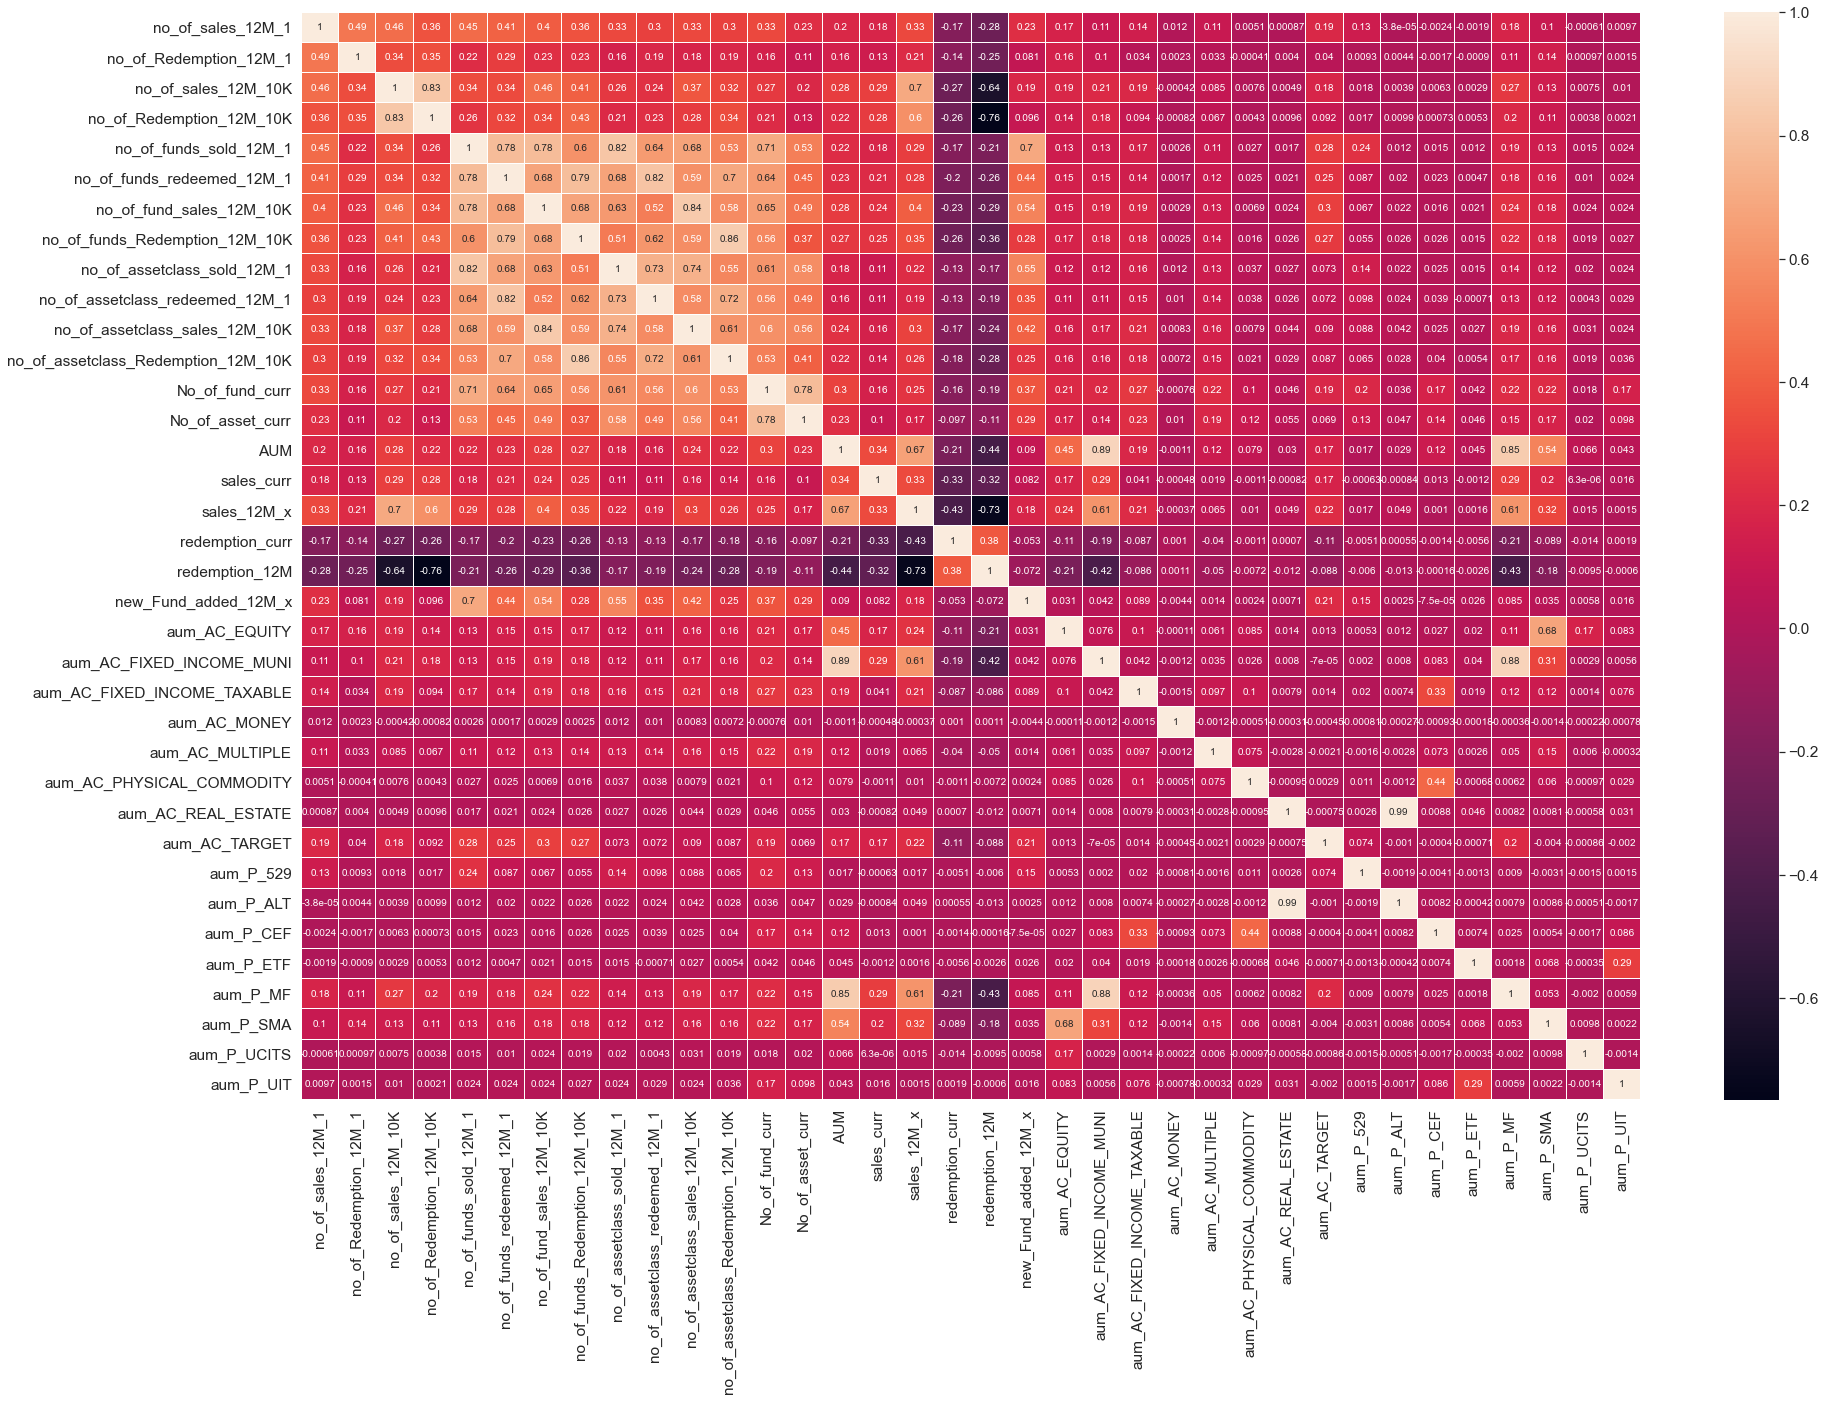

In [172]:
#Correlation map
#data.columns.values

plt.figure(figsize=(30,20))
#Compute the correlation matrix
corr=data[['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
       'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K',
       'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
       'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_x',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT']].corr()
sns.heatmap(corr,linecolor='white',linewidths=0.1,annot=True)
plt.show()

In [173]:
#%%Exploratory Data Analysis (EDA)
# data.head(10)
# X1='sales_12M_x'
# X2='sales_curr'
# X3='redemption_curr'
# data[[X1,X2,X3]].describe()
# data.hist()
# plt.close('all')

<h1>Regression</h1>

<h2>Plotting</h2>

<h3>Step 1 -> working with notnull y's</h3>

In [174]:
#%%Linear Regression to predict sales_12M_y
#Arranging X and y
#focusing on notnull y values.  model will be fit on notnull values.  null values will be predicted.
data_reg=data[data['sales_12M_y'].notnull()]
# data_reg.info()
data_reg_predict=data[data['sales_12M_y'].isnull()]
print('Shape of data_reg: {}'.format(data_reg.shape))
print('Shape of data_reg_predict: {}'.format(data_reg_predict.shape))



Shape of data_reg: (5074, 42)
Shape of data_reg_predict: (4931, 42)


In [175]:
data_reg.describe()

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,sales_12M_y,new_Fund_added_12M_y
count,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5074.000000,5.074000e+03,5.074000e+03,5.074000e+03,5074.000000,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5074.000000,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5074.000000
mean,38.198660,38.991920,4.375049,3.135396,2.442452,2.574300,1.041782,1.017935,1.352779,1.406583,0.674813,0.676389,3.238865,1.270595,8.309998e+05,3.409969e+04,3.146502e+05,-3.507054e+04,-2.116826e+05,0.867363,2.266455e+05,5.280047e+05,7.374048e+04,13.894909,3.686437e+04,1.615812e+03,1.653640e+03,3.831056e+04,5.415488e+03,1.335238e+03,3.494142e+04,15.254517,4.826200e+05,3.378857e+05,7.534470e+03,8.411872e+03,4.219882e+05,0.496847
std,133.901548,266.211684,14.606038,11.570420,2.879117,2.989847,1.697689,1.729338,1.052770,1.099811,0.856492,0.884703,3.766821,1.133115,4.127479e+06,2.715156e+05,1.402595e+06,2.746917e+05,1.039164e+06,1.528089,1.502606e+06,3.651236e+06,4.311041e+05,917.467997,2.762975e+05,3.088137e+04,5.279933e+04,6.750954e+05,5.339686e+04,5.198187e+04,3.539946e+05,676.819618,3.481129e+06,2.039665e+06,2.659805e+05,9.460394e+04,1.594769e+06,0.500039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.320885e+07,-3.073238e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,2.229475e+02,-4.395731e+03,-1.058376e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.390885e+03,0.000000
50%,7.000000,5.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,2.646857e+04,0.000000e+00,2.000000e+04,0.000000e+00,-1.640104e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,8.812240e+03,0.000000e+00,0.000000e+00,0.000000e+00,4.345532e+04,0.000000
75%,27.000000,25.000000,3.000000,2.000000,3.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,5.000000,2.000000,4.575019e+05,2.784667e+03,1.597230e+05,0.000000e+00,-1.312450e+02,1.000000,4.999553e+04,1.468312e+05,8.457746e+03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.262256e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.480376e+05,1.000000
max,4395.000000,12152.000000,330.000000,283.000000,32.000000,33.000000,19.000000,21.000000,5.000000,5.000000,5.000000,4.000000,32.000000,6.000000,2.232411e+08,9.639535e+06,5.434650e+07,0.000000e+00,0.000000e+00,16.000000,7.196701e+07,2.

In [176]:
# #Removing a few rows that have high inputs
# indexToRemove=data_reg[(data_reg['sales_12M_x']>2e7) | (data_reg['AUM']>4e7)].index
# data_reg.drop(index=indexToRemove,inplace=True)
# data_reg.reset_index(drop=True,inplace=True)

In [177]:
#Plotting Xs vs y
def plot_compare(x,y):
    plt.figure()
    plt.scatter(x,y)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()
    return None

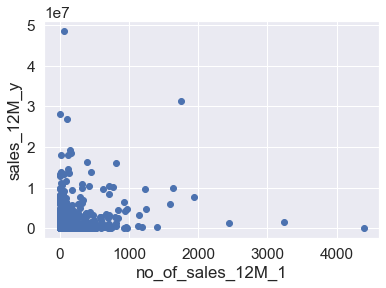

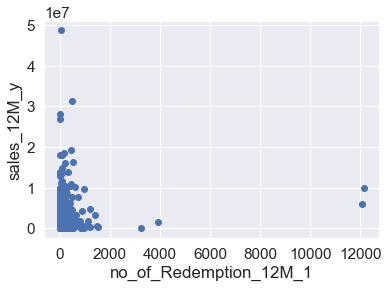

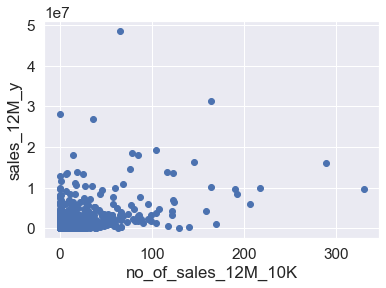

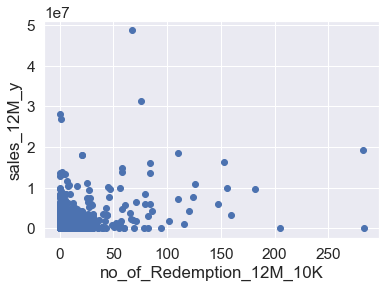

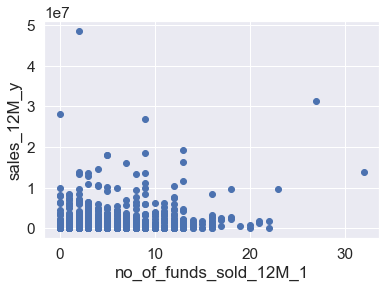

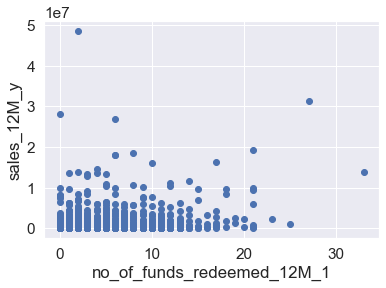

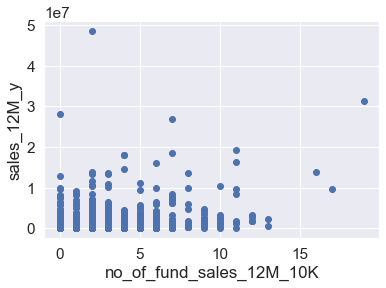

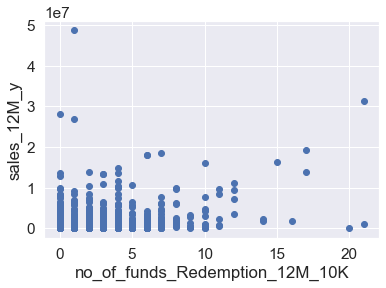

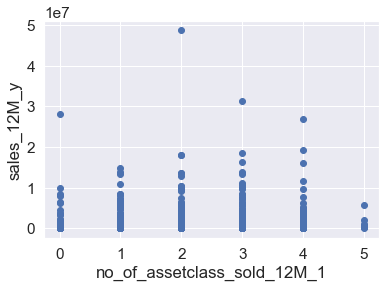

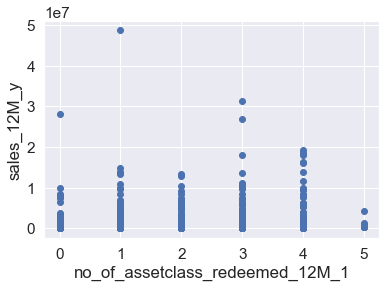

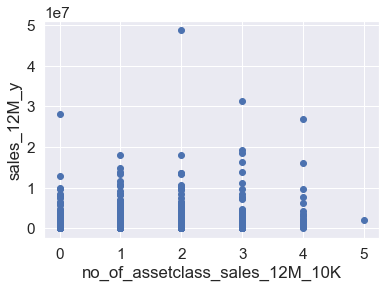

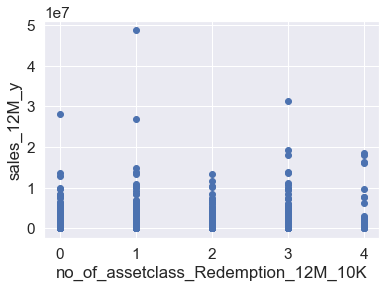

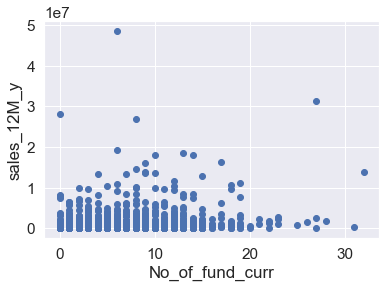

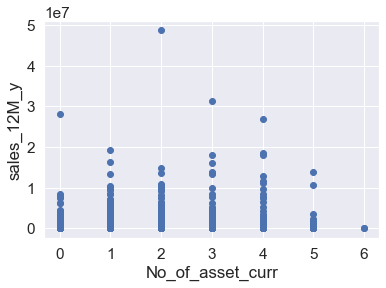

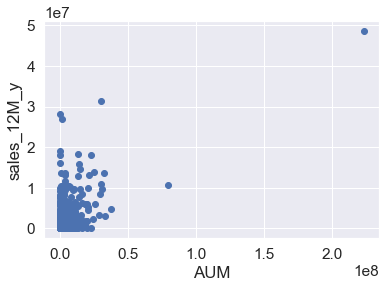

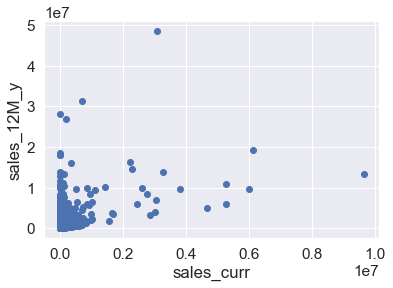

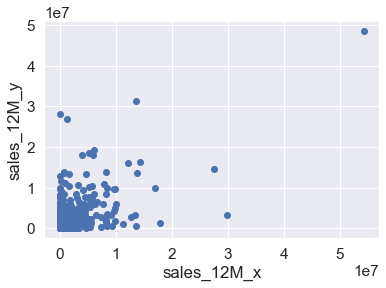

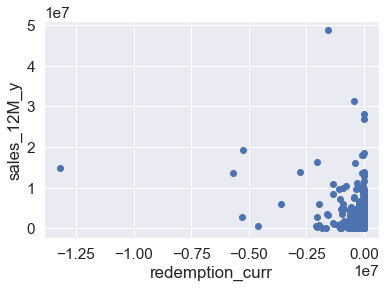

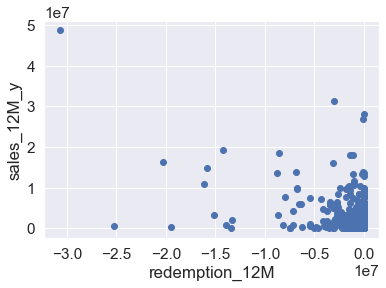

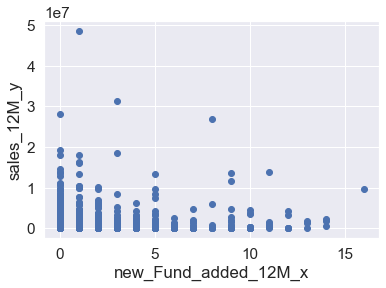

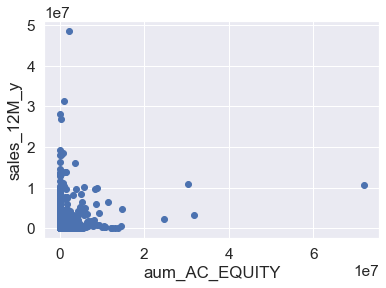

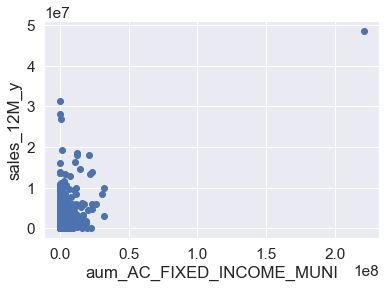

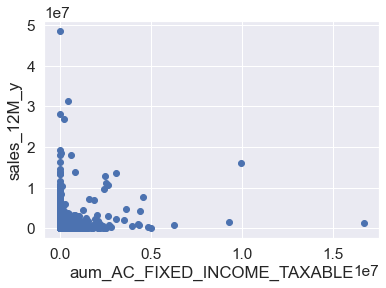

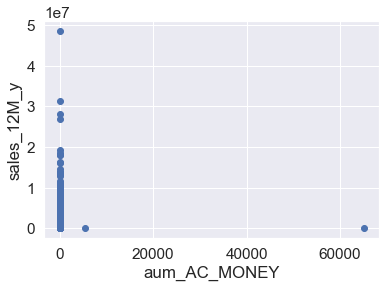

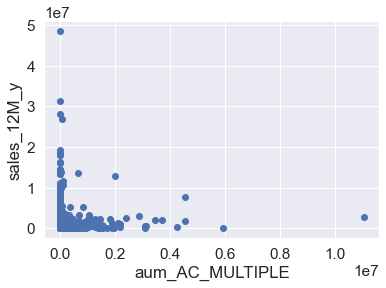

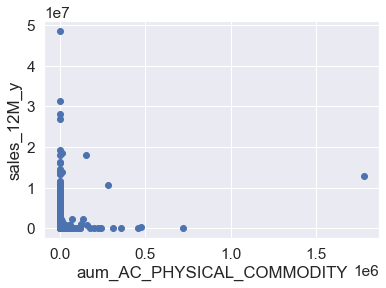

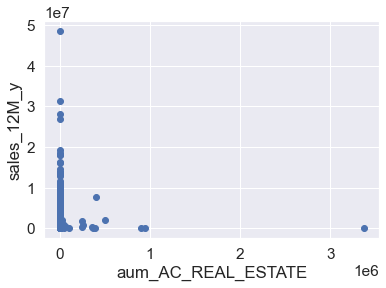

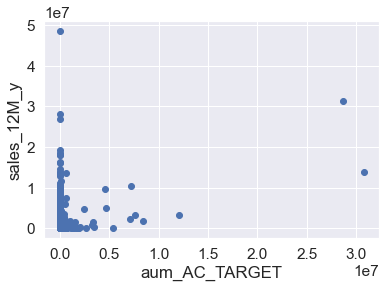

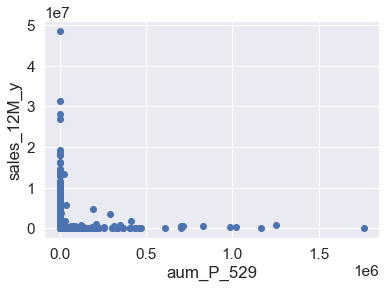

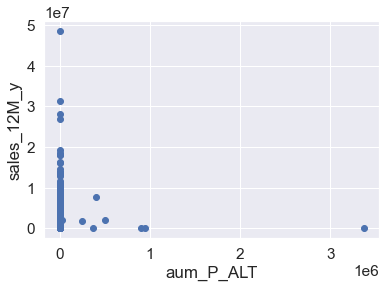

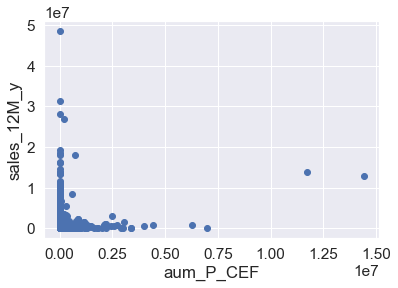

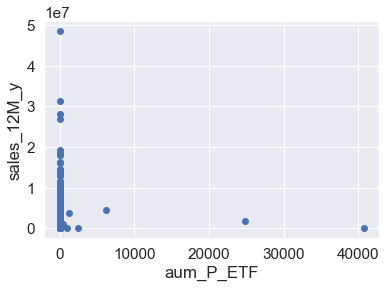

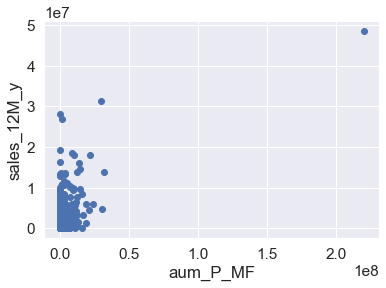

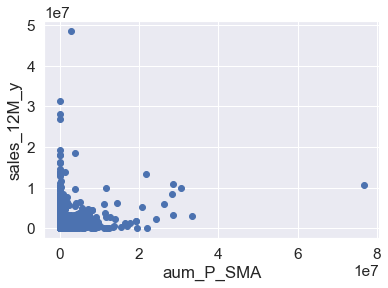

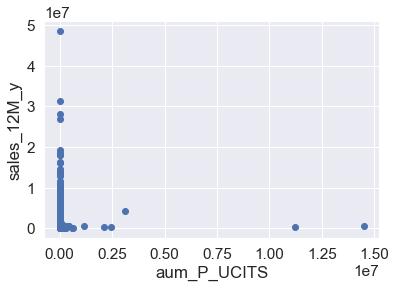

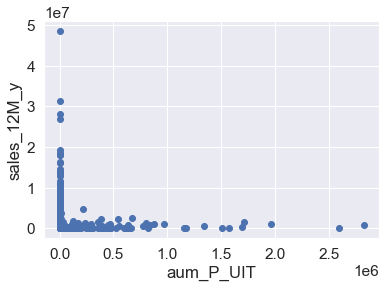

In [178]:
# Xs=['no_of_sales_12M_1', 'no_of_Redemption_12M_1','no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
#     'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
#     'No_of_fund_curr','No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
#     'redemption_curr', 'redemption_12M']
Xs=['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
       'no_of_sales_12M_10K', 'no_of_Redemption_12M_10K',
       'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K',
       'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
       'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_x',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT']
for x1 in Xs:
    plot_compare(data_reg[x1],data_reg['sales_12M_y'])


In [179]:
#Set Xs
Xs=['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
'No_of_fund_curr','AUM', 'sales_curr', 'sales_12M_x',
'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_x',
'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI']

In [180]:
data_reg['sales_12M_y'].median()

43455.325

In [181]:
# sns.pairplot(data_reg[['no_of_sales_12M_1', 'no_of_Redemption_12M_1',
#        'no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1',
#        'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
#        'No_of_fund_curr','No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_x',
#        'redemption_curr', 'redemption_12M','sales_12M_y']])
# plt.show()

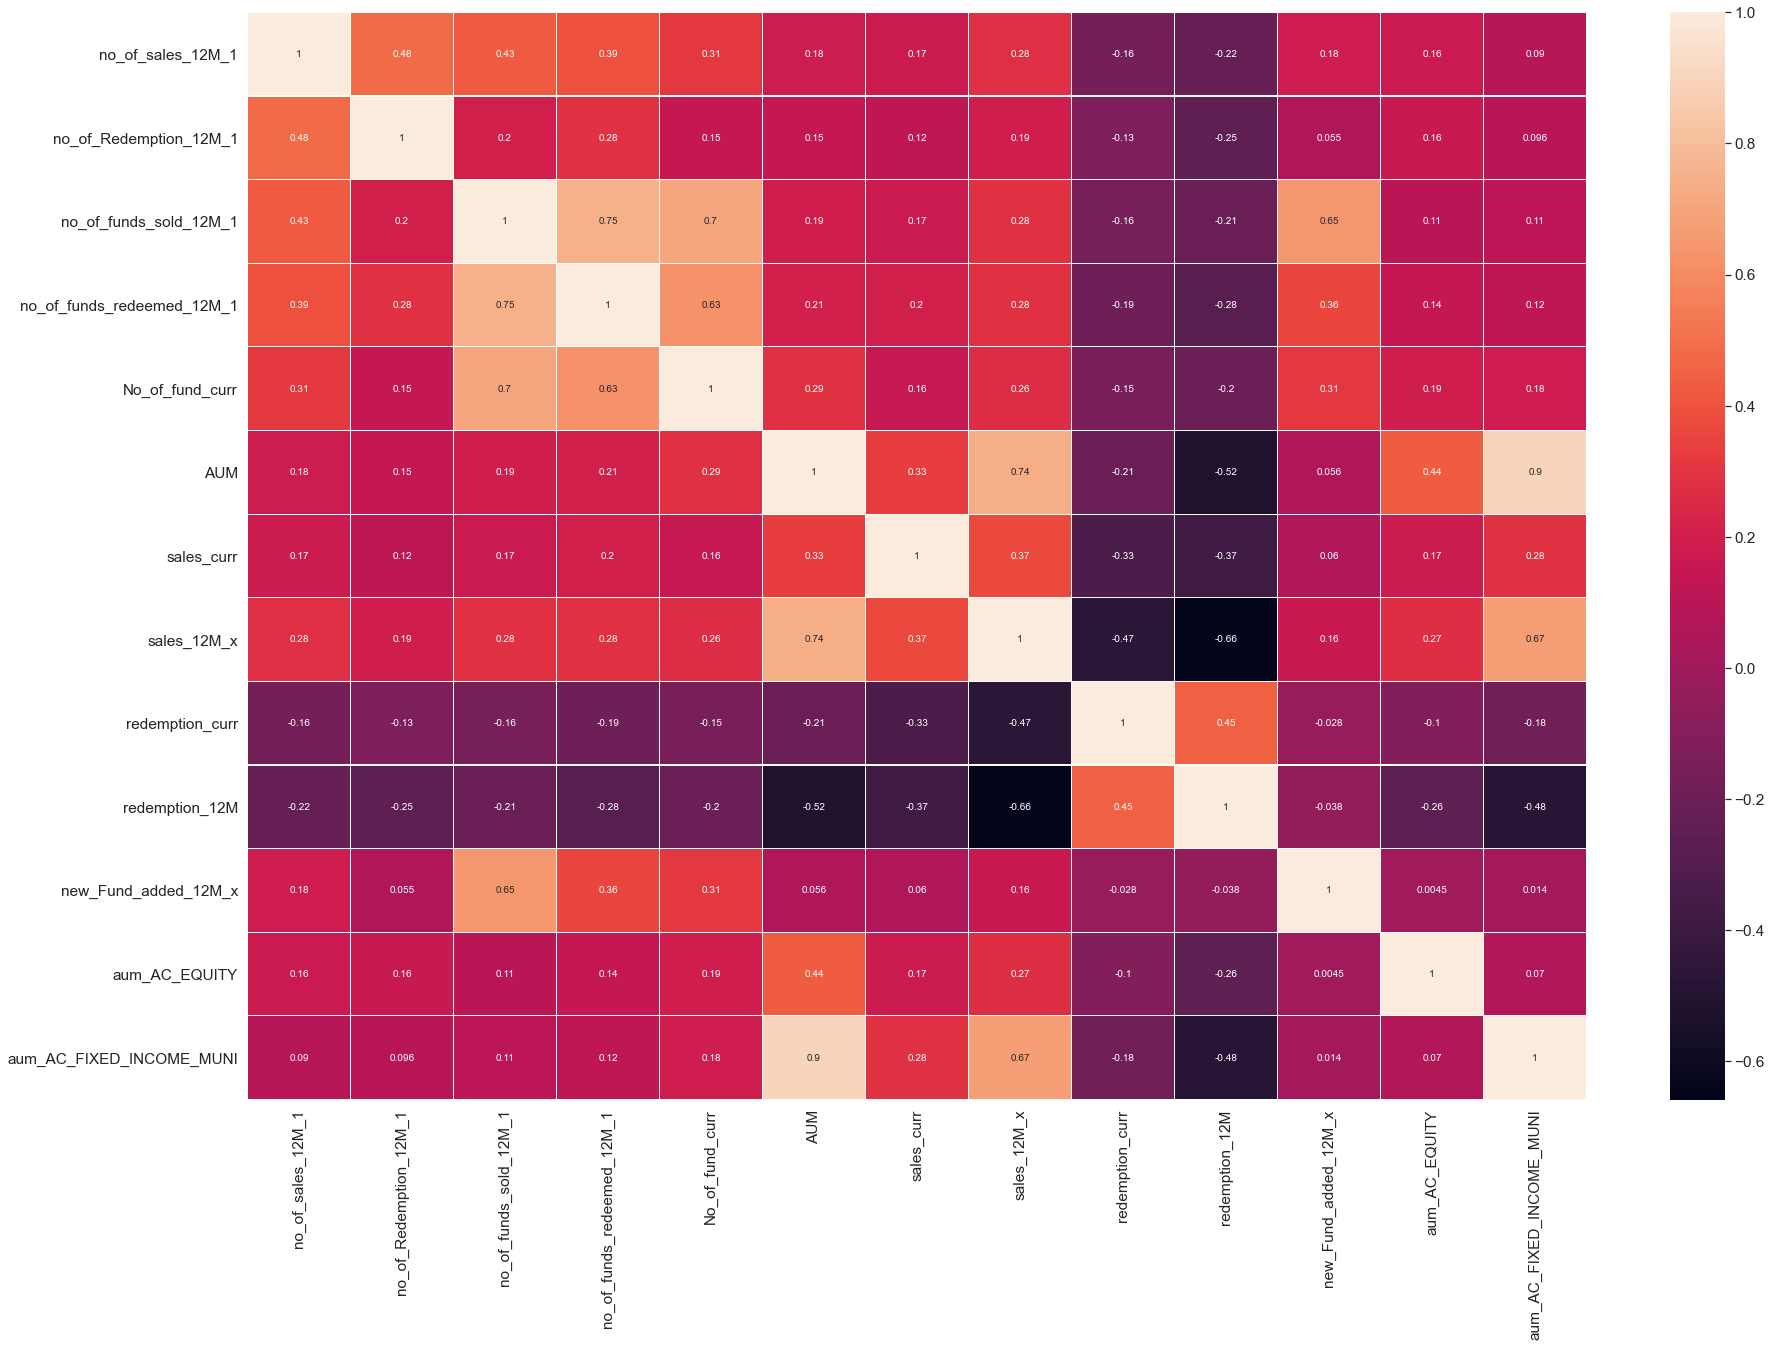

In [182]:
#Correlation map of data_reg
#data.columns.values

plt.figure(figsize=(30,20))
#Compute the correlation matrix
corr=data_reg[Xs].corr()
sns.heatmap(corr,linecolor='white',linewidths=0.1,annot=True)
plt.show()

In [183]:
#Plotting histogram of some Xs
def plot_histBox(data1,name1,data2,name2):
    '''
    Inputs:
    data1: data series 1 to plot
    name1: name of data series 1
    data2: data series 2 to plot
    name2: name of data series 2
    
    Output:
    plots of histogram and boxplot
    '''
    
    fig, (ax1,ax2)=plt.subplots(1,2)
    ax1.hist(data1)
    ax2.boxplot(data1,showbox=True)
    fig.suptitle(name1)
    plt.show()
    fig, (ax3,ax4)=plt.subplots(1,2)
    ax3.hist(data2)
    ax4.boxplot(data2,showbox=True)
    fig.suptitle(name2)
    plt.show()
    return None

In [184]:
#Calculating Q3+1.5*IQR
def calc_uppLimit(data1,name1):
    '''
    Input: data series,name1
    Output: upper limit to remove outliers
    '''
    print('Std of '+name1+': {}'.format(data1.std()))
    print('3rd quartile of '+name1+': {}'.format(data1.quantile(0.75)))
    limit=data1.quantile(0.75)+1.5*(data1.quantile(0.75)-data1.quantile(0.25))
    print('Upper limit in '+name1+' to remove outliers: {}'.format(limit))
    return limit

In [185]:
#plot_histBox(data_reg[X1],X1,data_reg[X2],X2)

In [186]:
#limit_X1=calc_uppLimit(data_reg[X1],X1)

<h3>Step 2 -> removing outliers in sales_12M_x</h3>

In [187]:
# data_reg2=data_reg[data_reg[X1]<=limit_X1] #removing outliers from sales_12M_x
# plot_histBox(data_reg2[X1],X1,data_reg2[X1],X1)

<h3>Step 3 -> removing outliers in sales_curr</h3>

In [188]:
# limit_AUM=calc_uppLimit(data_reg2[X2],X2)

<h3>Step 2 -> removing outliers in sales_curr</h3>

In [189]:
# data_reg3=data_reg2[data_reg2[X2]<=limit_AUM] #removing outliers from sales_12M_x
# plot_histBox(data_reg3[X1],X1,data_reg3[X2],X2)

In [190]:
#Removing outliers did not help. Stick to all Xs
X=data_reg[Xs]
y=data_reg['sales_12M_y']
X_predict=data_reg_predict[Xs]

In [191]:
X.describe()

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,No_of_fund_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI
count,5074.000000,5074.000000,5074.000000,5074.000000,5074.000000,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5.074000e+03,5074.000000,5.074000e+03,5.074000e+03
mean,38.198660,38.991920,2.442452,2.574300,3.238865,8.309998e+05,3.409969e+04,3.146502e+05,-3.507054e+04,-2.116826e+05,0.867363,2.266455e+05,5.280047e+05
std,133.901548,266.211684,2.879117,2.989847,3.766821,4.127479e+06,2.715156e+05,1.402595e+06,2.746917e+05,1.039164e+06,1.528089,1.502606e+06,3.651236e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.320885e+07,-3.073238e+07,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,2.229475e+02,-4.395731e+03,-1.058376e+05,0.000000,0.000000e+00,0.000000e+00
50%,7.000000,5.000000,2.000000,2.000000,2.000000,2.646857e+04,0.000000e+00,2.000000e+04,0.000000e+00,-1.640104e+04,0.000000,0.000000e+00,0.000000e+00
75%,27.000000,25.000000,3.000000,4.000000,5.000000,4.575019e+05,2.784667e+03,1.597230e+05,0.000000e+00,-1.312450e+02,1.000000,4.999553e+04,1.468312e+05
max,4395.000000,12152.000000,32.000000,33.000000,32.000000,2.232411e+08,9.639535e+06,5.434650e+07,0.000000e+00,0.000000e+00,16.000000,7.196701e+07,2.209272e+08


<h2>Scaling</h2>

In [192]:
transformer=RobustScaler()
X_transformed=transformer.fit_transform(X)

In [193]:
def plot_transformed(X,Xs):
    for i in range(X.shape[1]):
        plt.figure(figsize=(5,5))
        plt.hist(X[:,i])
        plt.xlabel(Xs[i])

    plt.tight_layout()
    plt.show()
    return None

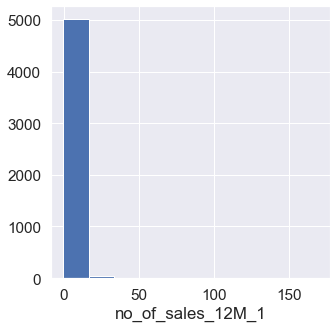

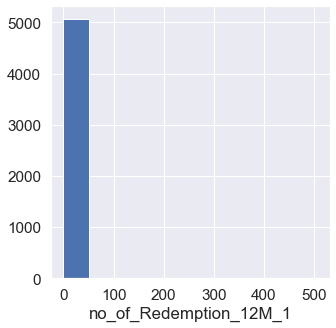

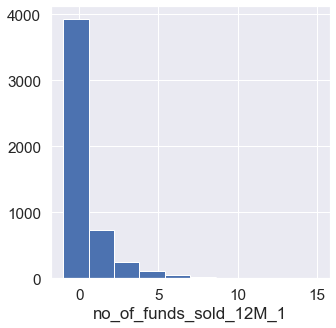

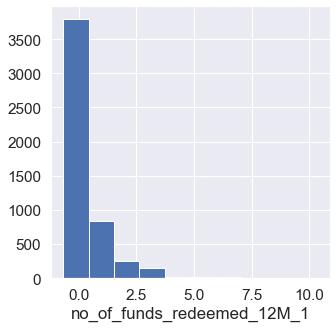

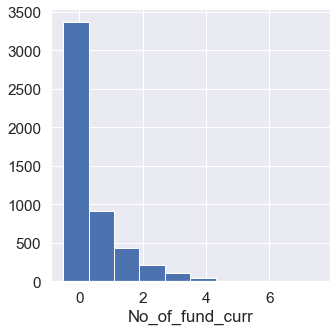

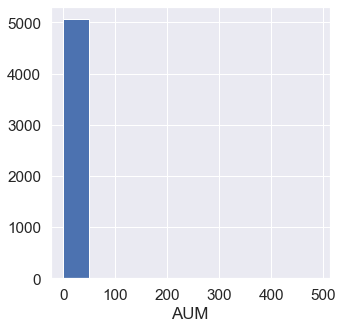

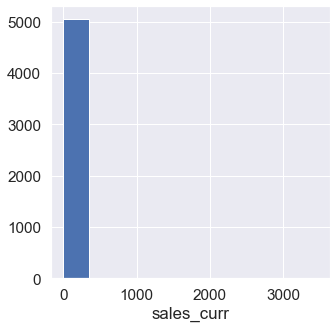

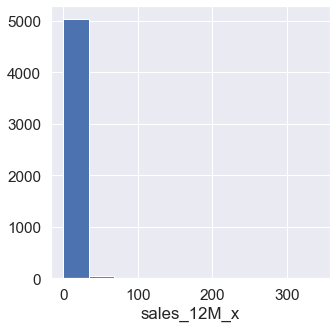

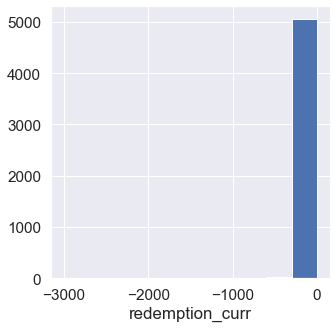

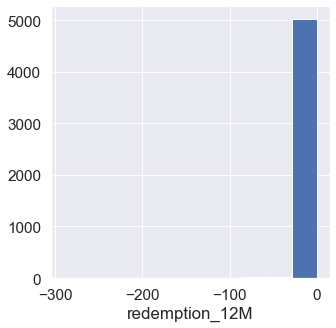

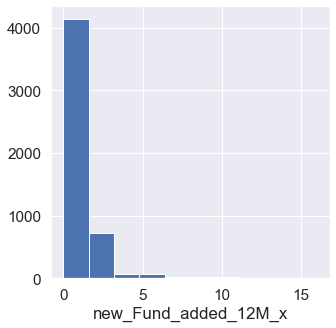

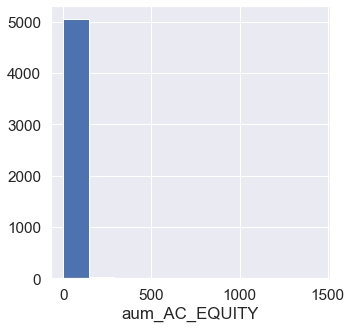

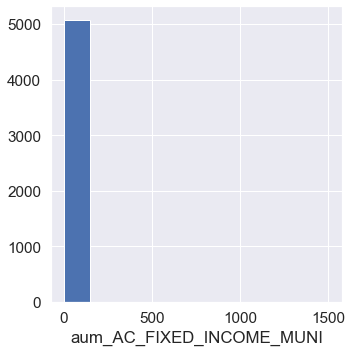

In [194]:
plot_transformed(X_transformed,Xs)
# for i in range(X_transformed.shape[1]):
#     plt.figure(figsize=(5,5))
#     plt.hist(X_transformed[:,i])
#     plt.xlabel(Xs[i])

# plt.tight_layout()
# plt.show()


In [195]:
#randomly separating train and test

X_train,X_test,y_train,y_test=train_test_split(X_transformed,y,test_size=0.25,random_state=30)

<h3>Dummy Regressor</h3>

In [196]:
#Dummy Regressor
dummy_regr=DummyRegressor(strategy='mean')
dummy_regr.fit(X_train,y_train)
print('R^2 of test: {}'.format(dummy_regr.score(X_test,y_test)))
print('R^2 of train: {}'.format(dummy_regr.score(X_train,y_train)))

R^2 of test: -0.0007094431201741802
R^2 of train: 0.0


In [197]:
#fitting LinearRegression
linreg=linear_model.LinearRegression(normalize=True)
linreg.fit(X_train,y_train)
print('R^2 of test: {}'.format(linreg.score(X_test,y_test)))
print('R^2 of train: {}'.format(linreg.score(X_train,y_train)))


R^2 of test: 0.6395504979285178
R^2 of train: 0.4136886050284567


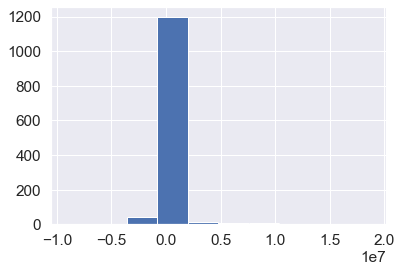

In [198]:
yTest_predict=linreg.predict(X_test)
residuals=y_test-yTest_predict
plt.hist(residuals)
plt.show()

In [199]:
#SUPPORT VECTOR REGRESSION
#LinearRegression is not giving good scores. Trying Support Vector Regression
kern=['linear','poly','rbf','sigmoid']
for trial in kern:
    svm_reg=SVR(kernel=trial,verbose=True)
    svm_reg.fit(X_train,y_train)
    print('Kernel of SVR: '+trial)
    print('R^2 of test: {}'.format(svm_reg.score(X_test,y_test)))
    print('R^2 of train: {}'.format(svm_reg.score(X_train,y_train)))

[LibSVM]Kernel of SVR: linear
R^2 of test: 0.41317087465049374
R^2 of train: 0.23049704236901725
[LibSVM]Kernel of SVR: poly
R^2 of test: 0.052510160774012715
R^2 of train: 0.055426028009536665
[LibSVM]Kernel of SVR: rbf
R^2 of test: -0.04401531286363958
R^2 of train: -0.06468498973886261
[LibSVM]Kernel of SVR: sigmoid
R^2 of test: -0.04399599364041973
R^2 of train: -0.06467152589327507


In [200]:
#STOCHASTIC GRADIENT DESCENT
sgd_reg=SGDRegressor()
sgd_reg.fit(X_train,y_train)
print('R^2 of test: {}'.format(sgd_reg.score(X_test,y_test)))
print('R^2 of train: {}'.format(sgd_reg.score(X_train,y_train)))

R^2 of test: -412381976266.60657
R^2 of train: -448569579611.67194


In [201]:
#GRADIENT BOOSTING REGRESSOR
gb_reg=GradientBoostingRegressor()
gb_reg.fit(X_train,y_train)
print('R^2 of test: {}'.format(gb_reg.score(X_test,y_test)))
print('R^2 of train: {}'.format(gb_reg.score(X_train,y_train)))

R^2 of test: 0.39404212728092736
R^2 of train: 0.7324489036370115


In [202]:
#GRID_SEARCH
param_grid={'loss':['ls','lad','huber','quantile'],
           'learning_rate':[0.05,0.1,0.5],
           'max_depth':[3,4,5,6],'n_estimators':[50,100,150]}
gb_reg_GS=GridSearchCV(gb_reg,param_grid,cv=2,return_train_score=True,scoring='r2')
gb_reg_GS.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'loss': ['ls', 'lad', 'huber', 'quantile'],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='r2')

In [203]:
gb_reg_GS_results=pd.DataFrame(data=gb_reg_GS.cv_results_)

In [204]:
gb_reg_GS_results.sort_values(by='rank_test_score',axis=0,)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
70,0.729187,0.013885,0.006133,0.004063,0.1,lad,6,100,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep...",0.349178,0.365494,0.357336,0.008158,1,0.617737,0.570223,0.593980,0.023757
62,0.512908,0.007317,0.001036,0.001036,0.1,lad,3,150,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep...",0.347694,0.364375,0.356034,0.008340,2,0.530255,0.469919,0.500087,0.030168
64,0.445258,0.000344,0.006107,0.004039,0.1,lad,4,100,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep...",0.358562,0.351651,0.355107,0.003456,3,0.551867,0.472588,0.512227,0.039639
31,0.718741,0.010106,0.005047,0.005047,0.05,huber,5,100,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",0.376110,0.329237,0.352673,0.023436,4,0.644316,0.589686,0.617001,0.027315
17,0.682369,0.003889,0.008032,0.000017,0.05,lad,4,150,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de...",0.354379,0.340327,0.347353,0.007026,5,0.523629,0.472676,0.498153,0.025476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.820191,0.017146,0.005119,0.002980,0.5,quantile,5,150,"{'learning_rate': 0.5, 'loss': 'quantile', 'ma...",-0.332313,-0.350465,-0.341389,0.009076,140,0.547052,0.366542,0.456797,0.090255
139,0.559043,0.007195,0.000000,0.000000,0.5,quantile,5,100,"{'learning_rate': 0.5, 'loss': 'quantile', 'ma...",-0.198568,-0.556700,-0.377634,0.179066,141,0.510139,0.334971,0.422555,0.087584
141,0.345204,0.000360,0.004034,0.004034,0.5,quantile,6,50,"{'learning_rate': 0.5, 'loss': 'quantile', 'ma...",-0.582036,-0.260369,-0.421202,0.160834,142,0.525499,0.623349,0.574424,0.048925
135,0.218143,0.006323,0.000000,0.000000,0.5,quantile,4,50,"{'learning_rate': 0.5, 'loss': 'quantile', 'ma...",-0.675823,-0.329526,-0.502675,0.173149,143,0.266596,0.304684,0.285640,0.019044


In [205]:
print('Best estimator:')
print(gb_reg_GS.best_estimator_)
print('Best score:')
print(gb_reg_GS.best_score_)
print('Best params:')
print(gb_reg_GS.best_params_)

Best estimator:
GradientBoostingRegressor(loss='lad', max_depth=6)
Best score:
0.3573358388767249
Best params:
{'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 100}


In [206]:
#Predict for empty y's
X_predict_transformed=transformer.fit_transform(X_predict)
y_predict=gb_reg_GS.predict(X_predict_transformed)

Text(0.5, 1.0, 'y')

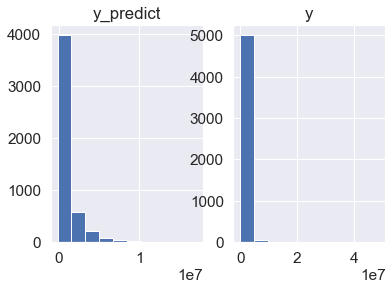

In [207]:
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.hist(y_predict)
ax1.set_title('y_predict')

ax2.hist(y)
ax2.set_title('y')

In [208]:
X_predict.head()

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,No_of_fund_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI
1,0.0,0.0,0.0,0.0,1.0,19629.0,0.0,0.0,0.0,0.000000,0.0,0.0,19629.000000
2,0.0,0.0,0.0,0.0,0.0,1758.7,0.0,0.0,0.0,0.000000,0.0,0.0,1758.700000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
8,5.0,4.0,1.0,1.0,0.0,0.0,0.0,10060.8,0.0,-6752.526579,0.0,0.0,3308.273421
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [209]:
X_predict.index.values

array([    1,     2,     4, ...,  9995,  9996, 10004], dtype=int64)

In [210]:
#Filling in empty y values with y_predict
data.loc[X_predict.index.values,'sales_12M_y']=y_predict

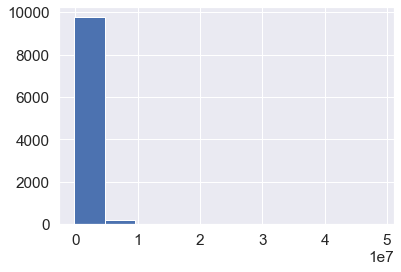

In [211]:
#data.info()
data['sales_12M_y'].hist()

<h1>Classification</h1>

In [212]:
data.head()
data.tail()
data['new_Fund_added_12M_y'].describe()

count    5074.000000
mean        0.496847
std         0.500039
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: new_Fund_added_12M_y, dtype: float64

In [213]:
#Separating dataframe with labels and without labels
data_class=data[data['new_Fund_added_12M_y'].notnull()]
data_class_predict=data[data['new_Fund_added_12M_y'].isnull()]
print('Count of labeled new_Fund_added_12M_y: {}'.format(data_class.shape))
print('Count of unlabeled new_Fund_added_12M_y: {}'.format(data_class_predict.shape))

Count of labeled new_Fund_added_12M_y: (5074, 42)
Count of unlabeled new_Fund_added_12M_y: (4931, 42)


In [214]:
#creating X and Y
X_class=data_class[Xs]
y_class=data_class['new_Fund_added_12M_y']
X_class_predict=data_class_predict[Xs]

In [215]:
#transform X values
transformer=RobustScaler()
X_class_transformed=transformer.fit_transform(X_class)

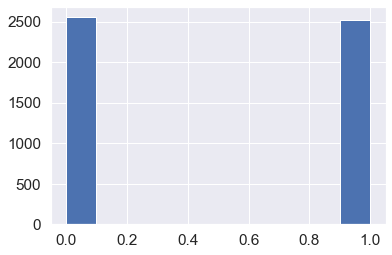

In [216]:
plt.hist(y_class);
#observing balanced classes

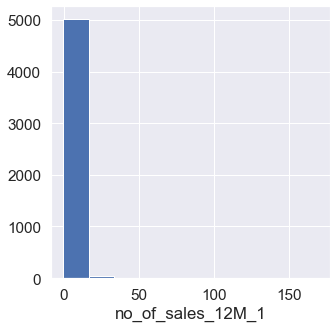

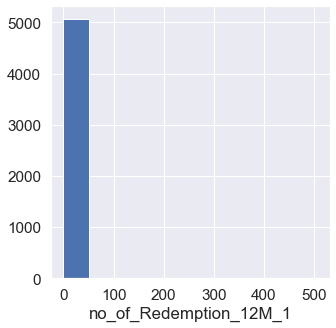

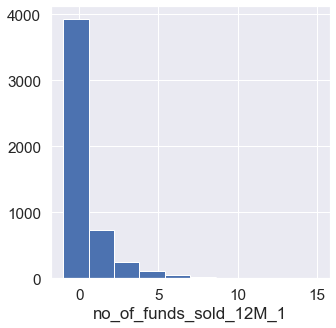

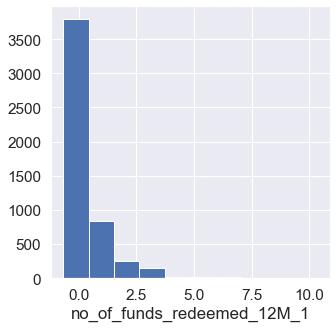

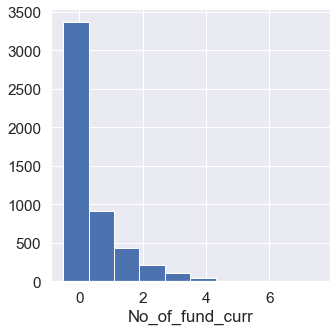

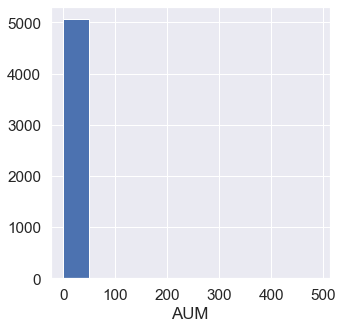

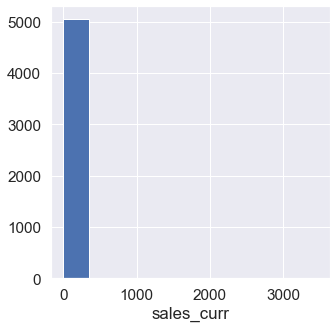

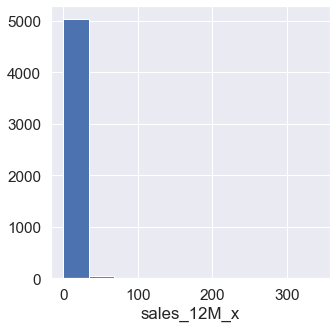

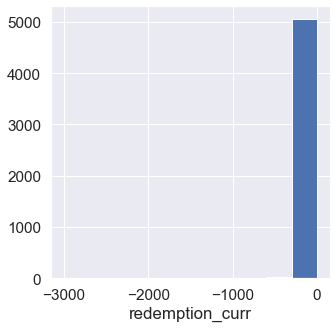

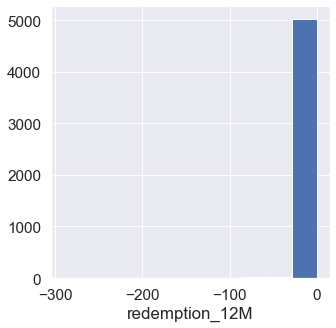

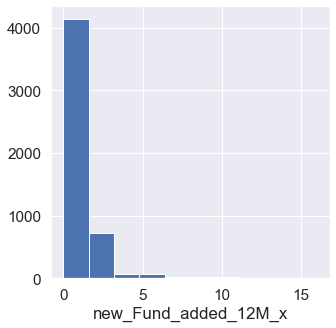

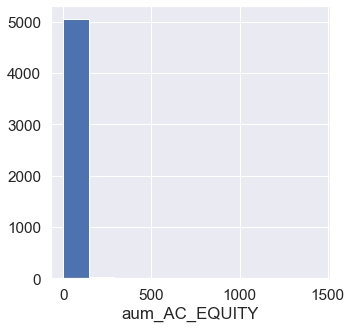

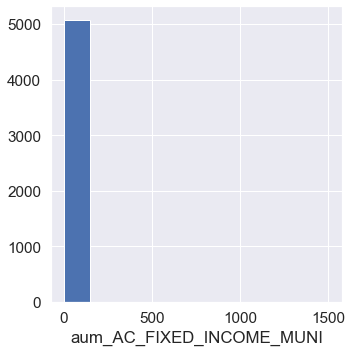

In [217]:
plot_transformed(X_class_transformed,Xs)

In [218]:
#randomly separating train and test

X_train,X_test,y_train,y_test=train_test_split(X_class_transformed,y_class,test_size=0.25,random_state=30)

In [219]:
#GRADIENT BOOSTING CLASSIFIER
gb_clf=GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
print('Mean accuracy of test: {}'.format(gb_clf.score(X_test,y_test)))
print('Mean accuracy of train: {}'.format(gb_clf.score(X_train,y_train)))

Mean accuracy of test: 0.6430260047281324
Mean accuracy of train: 0.7450722733245729


In [220]:
y_test_predict=gb_clf.predict(X_test)

In [221]:
X_class_predict_transformed=transformer.fit_transform(X_class_predict)
fund_2019_probs=gb_clf.predict_proba(X_class_predict_transformed)
fund_2019=gb_clf.predict(X_class_predict_transformed)

In [222]:
data.loc[data[data['new_Fund_added_12M_y']==0].index.values,'fund_2019_probs']=0
data.loc[data[data['new_Fund_added_12M_y']==1].index.values,'fund_2019_probs']=1
data.loc[X_class_predict.index.values,'new_Fund_added_12M_y']=fund_2019
data.loc[X_class_predict.index.values,'fund_2019_probs']=np.max(fund_2019_probs,axis=1)

In [223]:
data.head()
#data.loc[X_class.index.values].head(30)

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_x,redemption_curr,redemption_12M,new_Fund_added_12M_x,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_x,sales_12M_y,new_Fund_added_12M_y,refresh_date_y,Firm name,fund_2019_probs
0,0047433,21.0,38.0,0.0,1.0,5.0,5.0,0.0,1.0,2.0,2.0,0.0,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,0.0,0.0,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105000,0.0,2019-12-31,"UBS Financial Services, Inc.",0.000000
1,4461312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19629.00,0.0,0.0,0.000,0.000,0.0,0.0,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,451406.254517,0.0,2019-12-31,Charles Schwab Investor Services,0.620805
2,4491079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.0,0.0,0.000,0.000,0.0,0.0,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,464570.855488,0.0,2019-12-31,The O.N. Equity Sales Company,0.632472
3,0107408,20.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,57943.00,5459.0,52484.0,0.000,0.000,1.0,0.0,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000000,1.0,2019-12-31,"Northwestern Mutual Investment Services, LLC",1.000000
4,85101140503769936458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,2018-12-31,11794.542266,0.0,2019-12-31,"Berthel, Fisher & Co. Financial Services, Inc.",0.636787


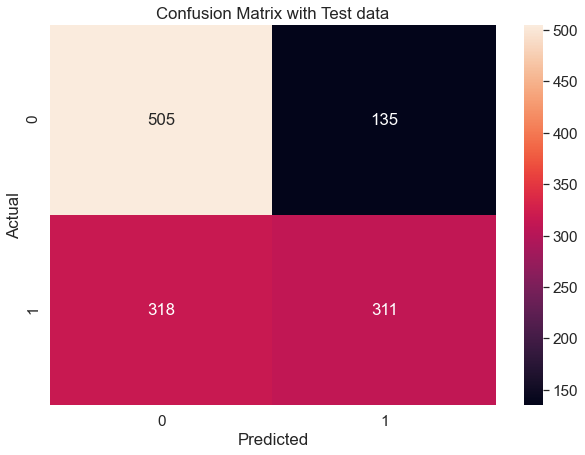

In [224]:
#Creating confusion matrix
data_cm=confusion_matrix(y_test,y_test_predict)
df_cm=pd.DataFrame(data=data_cm)
df_cm.index.name='Actual'
df_cm.columns.name='Predicted'
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix with Test data')
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,fmt='.0f')

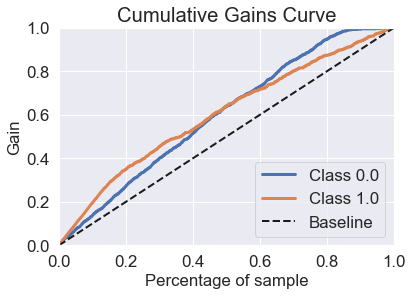

In [225]:
#Plotting cumulative gain curve
y_test_predictProba=gb_clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test,y_test_predictProba)
plt.show()

<h1>Lift Chart</h1>

In [226]:
data_result=data[['CONTACT_ID','sales_12M_x','new_Fund_added_12M_x','sales_12M_y','new_Fund_added_12M_y','fund_2019_probs','Firm name']]

<h2>Lift Chart for Classification</h2>

In [227]:
data_resultSorted=data_result.sort_values(by='fund_2019_probs',ascending=False)
# data_resultSorted_fundAdded=data_resultSorted[data_resultSorted['new_Fund_added_12M_y']==1]
data_resultSorted.reset_index(inplace=True,drop=True)
data_resultSorted['deciles']=pd.qcut(data_resultSorted.index.values,10,duplicates='drop',labels=False)
data_resultSorted['deciles']+=1
data_resultSorted

,CONTACT_ID,sales_12M_x,new_Fund_added_12M_x,sales_12M_y,new_Fund_added_12M_y,fund_2019_probs,Firm name,deciles
0,4393590,25.60,1.0,1124.530,1.0,1.0,"Cuna Brokerage Services, Inc.",1
1,85202151524662563318,51744.61,4.0,58101.770,1.0,1.0,"Northwestern Mutual Investment Services, LLC",1
2,10761192453789258003,0.00,0.0,71905.570,1.0,1.0,J.P. Morgan Chase,1
3,10751182807046446378,51742.34,3.0,14894.610,1.0,1.0,Lincoln Investment Planning,1
4,85101142503431111338,343.97,0.0,5130.170,1.0,1.0,Edward Jones,1
...,...,...,...,...,...,...,...,...
10000,85202112125120155819,7656.48,0.0,270.310,0.0,0.0,"Ameriprise Financial Services, Inc.",10
10001,0305238,2632198.32,4.0,1461753.350,0.0,0.0,"Wells Fargo Advisors Financial Network, LLC",10
10002,0309648,10469.85,0.0,19807.345,0.0,0.0,Merrill Lynch,10
10003,4416971,375250.00,2.0,450353.500,0.0,0.0,Wells Fargo Advisors,10


In [228]:
data_fund=data_resultSorted.groupby(by='deciles').mean()
data_fund_sum=data_resultSorted.groupby(by='deciles').sum()
# data_resultSorted['fund_2019_probs'].mean()
data_fund_sum

,sales_12M_x,new_Fund_added_12M_x,sales_12M_y,new_Fund_added_12M_y,fund_2019_probs
deciles,,,,,
1,2.734856e+08,861.0,5.286177e+08,1001.0,1001.000000
2,3.166399e+08,817.0,5.375832e+08,1000.0,1000.000000
3,2.070439e+08,642.0,1.557735e+09,559.0,907.686732
4,2.906157e+07,211.0,1.307635e+09,81.0,684.970988
5,1.036182e+06,19.0,1.313981e+08,27.0,638.815617
6,5.669825e+05,13.0,7.456965e+07,5.0,636.445538
7,5.720441e+07,93.0,6.590835e+08,112.0,609.038789
8,1.763284e+08,519.0,7.398866e+08,152.0,239.276412
9,3.064874e+08,871.0,2.769970e+08,0.0,0.000000


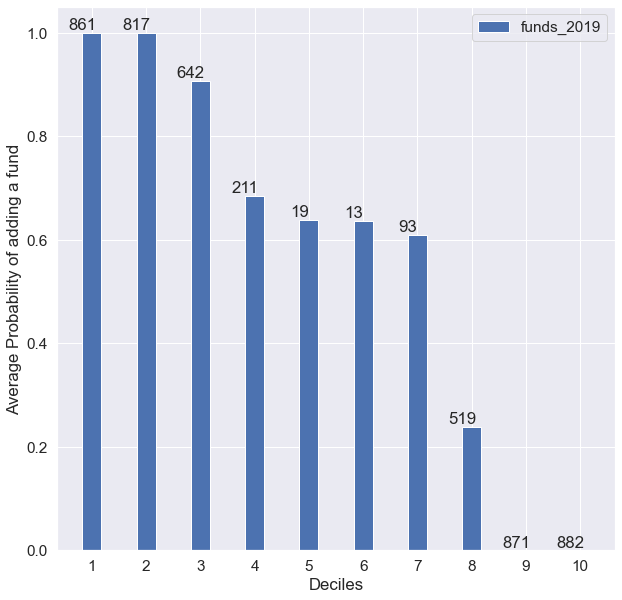

In [229]:
data_fund_np=data_fund_sum['new_Fund_added_12M_x'].map('{:,.0f}'.format).to_numpy()
data_fund_np=data_fund_np.astype(str)

width=0.35
fig,ax=plt.subplots(figsize=(10,10))
rects=ax.bar(np.arange(1,11),data_fund['fund_2019_probs'],width,label='funds_2019')


ax.set_xlabel('Deciles')
ax.set_ylabel('Average Probability of adding a fund')

ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(np.arange(1,11))
ax.legend()

for i,rect in enumerate(rects):
    height=rect.get_height()
    ax.annotate(data_fund_np[i],xy=(rect.get_x(),height),
               xytext=(0,0),
               textcoords='offset points',
               ha='center',va='bottom')

# fig.tight_layout()
plt.show()

<h2>Lift Chart for Regression</h2>

In [230]:
data_resultSorted=data_result.sort_values(by='sales_12M_y',ascending=False)
data_resultSorted.reset_index(inplace=True,drop=True)
data_resultSorted['deciles']=pd.qcut(data_resultSorted.index.values,10,duplicates='drop',labels=False)
data_resultSorted['deciles']=data_resultSorted['deciles']+1
data_resultSorted

,CONTACT_ID,sales_12M_x,new_Fund_added_12M_x,sales_12M_y,new_Fund_added_12M_y,fund_2019_probs,Firm name,deciles
0,0268477,5.434650e+07,1.0,4.867638e+07,1.0,1.000000,Merrill Lynch,1
1,85201122073118152417,1.369969e+07,3.0,3.136082e+07,1.0,1.000000,LPL Financial LLC,1
2,85101142574918607490,0.000000e+00,0.0,2.809139e+07,1.0,1.000000,Cetera Advisor Networks LLC,1
3,4432415,1.254289e+06,8.0,2.688445e+07,1.0,1.000000,"BB&T Securities, LLC",1
4,85202162383812931980,6.097337e+06,0.0,1.914061e+07,1.0,1.000000,U.S. Bank Private Wealth Management,1
...,...,...,...,...,...,...,...,...
10000,0211342,0.000000e+00,0.0,-1.236363e+05,0.0,0.724088,"UBS Financial Services, Inc.",10
10001,4383581,0.000000e+00,0.0,-1.236363e+05,0.0,0.724088,"Signator Investors, Inc.",10
10002,4396503,0.000000e+00,0.0,-1.236363e+05,0.0,0.724088,Merrill Lynch,10
10003,0259694,0.000000e+00,0.0,-1.236363e+05,0.0,0.724088,Merrill Lynch,10


In [231]:
data_mean=data_resultSorted.groupby(by='deciles').mean()
data_mean

,sales_12M_x,new_Fund_added_12M_x,sales_12M_y,new_Fund_added_12M_y,fund_2019_probs
deciles,,,,,
1,780517.926079,0.777223,4.287404e+06,0.252747,0.684533
2,413388.380100,0.744000,1.147545e+06,0.461000,0.649952
3,197518.207046,0.490509,4.241112e+05,0.325674,0.599669
4,167496.308359,0.836000,1.691150e+05,0.507000,0.571874
5,89734.174426,0.739261,5.503357e+04,0.412587,0.491964
6,23292.428232,0.353000,2.130497e+04,0.241000,0.570066
7,13588.508453,0.095000,1.304603e+04,0.080000,0.613932
8,0.000000,0.000000,1.179454e+04,0.000000,0.636787
9,26728.103235,0.479000,8.132373e+03,0.289000,0.476504


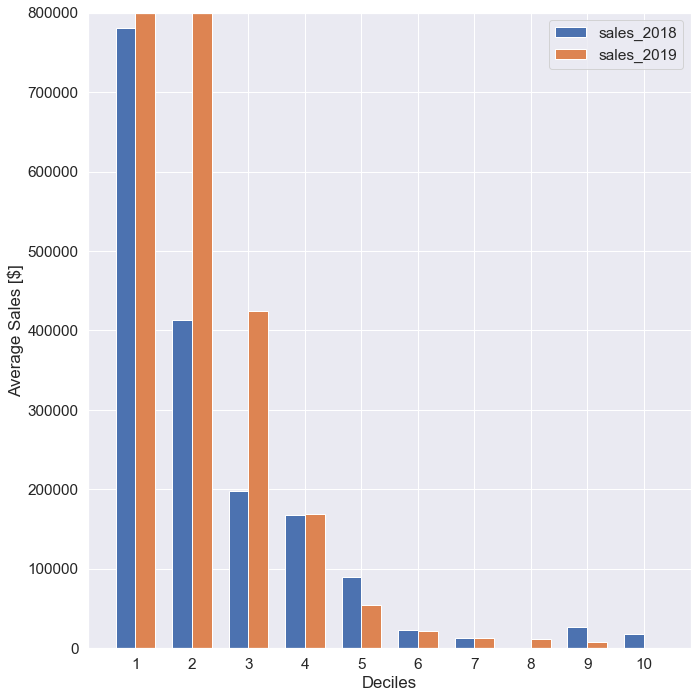

In [232]:
width=0.35
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(1,11)-width/2,data_mean['sales_12M_x'],width,label='sales_2018')
ax.bar(np.arange(1,11)+width/2,data_mean['sales_12M_y'],width,label='sales_2019')
plt.ylim(0,0.8e6)

ax.set_xlabel('Deciles')
ax.set_ylabel('Average Sales [$]')

ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(np.arange(1,11))
ax.legend()

fig.tight_layout()
plt.show()

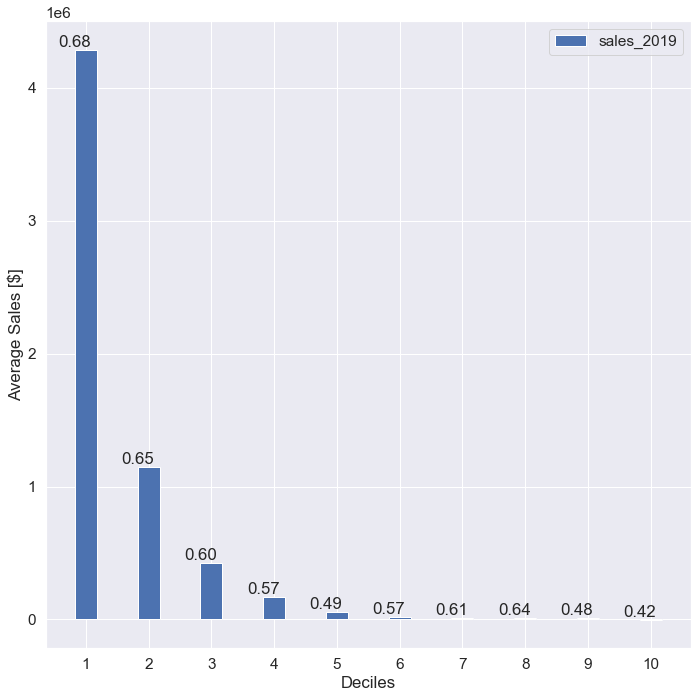

In [233]:
data_fund_np=data_mean['fund_2019_probs'].map('{:,.2f}'.format).to_numpy()
data_fund_np=data_fund_np.astype(str)

width=0.35
fig,ax=plt.subplots(figsize=(10,10))
# ax.bar(np.arange(1,11)-width/2,data_mean['sales_12M_x'],width,label='sales_2018')
rects=ax.bar(np.arange(1,11),data_mean['sales_12M_y'],width,label='sales_2019')
# plt.ylim(0,0.8e6)

ax.set_xlabel('Deciles')
ax.set_ylabel('Average Sales [$]')

ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(np.arange(1,11))
ax.legend()


for i,rect in enumerate(rects):
    height=rect.get_height()
    ax.annotate(data_fund_np[i],xy=(rect.get_x(),height),
               xytext=(0,0),
               textcoords='offset points',
               ha='center',va='bottom')

fig.tight_layout()
plt.show()

In [234]:
data_sum=data_resultSorted.groupby(by='deciles').sum()
data_count=data_resultSorted.groupby(by='deciles').count()
data_sum['actual_per_customer']=data_sum['sales_12M_y']/data_count['CONTACT_ID']
data_sum['actual_per_customer']

deciles
1     4.287404e+06
2     1.147545e+06
3     4.241112e+05
4     1.691150e+05
5     5.503357e+04
6     2.130497e+04
7     1.304603e+04
8     1.179454e+04
9     8.132373e+03
10   -2.602340e+03
Name: actual_per_customer, dtype: float64

In [235]:
data_resultSorted['sales_12M_y'].sum()/data_resultSorted.shape[0]

613659.1488285894

<h1>Firm Analysis</h1>

In [241]:
data_resultFirm=data_result.groupby('Firm name').sum()
data_resultFirm=data_resultFirm.sort_values(by='sales_12M_y',ascending=False)
data_resultFirm10=data_resultFirm.head(10)
data_resultFirm10

,sales_12M_x,new_Fund_added_12M_x,sales_12M_y,new_Fund_added_12M_y,fund_2019_probs
Firm name,,,,,
Merrill Lynch,4.041318e+08,586.0,7.159710e+08,325.0,452.206302
Morgan Stanley Wealth Management,2.443463e+08,388.0,6.536659e+08,319.0,515.638830
Wells Fargo Advisors,7.601384e+07,239.0,4.995862e+08,168.0,275.279575
LPL Financial LLC,1.252159e+08,379.0,4.971444e+08,225.0,461.637913
"Ameriprise Financial Services, Inc.",9.918651e+07,510.0,3.640207e+08,195.0,317.437754
"UBS Financial Services, Inc.",1.116138e+08,166.0,3.634140e+08,122.0,200.028303
Wells Fargo Banking & Investment Services,4.217397e+07,97.0,2.107862e+08,71.0,106.150868
Edward Jones,2.709633e+07,510.0,1.694751e+08,337.0,488.152642
"Raymond James Financial Services, Inc.",3.639697e+07,85.0,1.513712e+08,57.0,150.026215


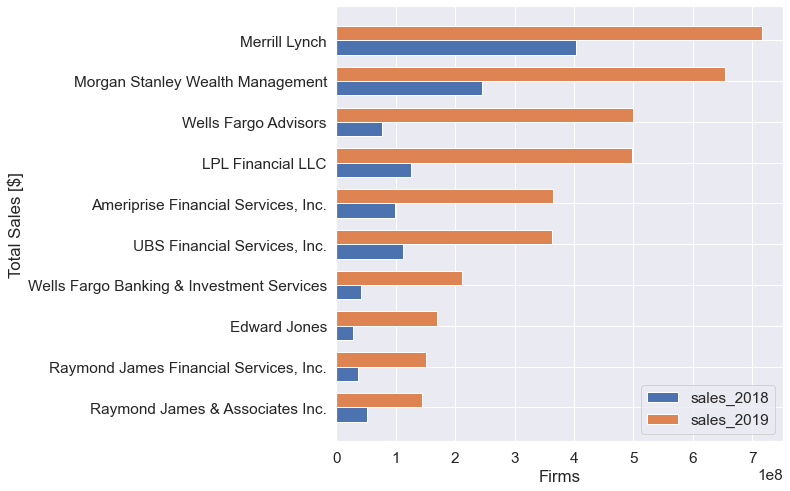

In [266]:
width=0.35
fig,ax=plt.subplots(figsize=(8,8))
ax.barh(np.arange(1,11)[::-1]-width/2,data_resultFirm10['sales_12M_x'],width,label='sales_2018')
ax.barh(np.arange(1,11)[::-1]+width/2,data_resultFirm10['sales_12M_y'],width,label='sales_2019')
# plt.ylim(0,0.8e6)

ax.set_xlabel('Firms')
ax.set_ylabel('Total Sales [$]')

ax.set_yticks(np.arange(1,11)[::-1])
ax.set_yticklabels(data_resultFirm10.index.values)


ax.legend()

# fig.tight_layout()
plt.show()

In [264]:
np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])